In [102]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


### Define functions used throughout the experiments

In [103]:
def generateX(n):
    x = np.random.randn(n)
    return(x)

def generateX_unif(n, delta = 3**0.5):
    x = np.random.uniform(low=-delta, high=delta, size=n)
    return(x)


def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


In [104]:
ntrain = 2000
n_new = 4000
n = ntrain + n_new

sigma = 0.1
alpha = 0.05 # 95% prediction interval for Y_new

### Experiment 1:

* true model is linear with homoskedastic Gaussian noise
* we fit a linear model
* we construct prediction interval using linear model

In [105]:

def generateLinearY(x, beta, b, sigma):
    n = len(x)
    eps = np.random.randn(n)
    y = beta*x + b + eps * sigma
    return y

In [106]:
def linearPredictionInterval(xtrain, ytrain, xnew, alpha):
    xtrain = xtrain.reshape(-1, 1)
    n1 = xtrain.shape[0]
    
    res = LinearRegression().fit(xtrain, ytrain)

# fit beta_hat
    betahat = res.coef_
    bhat = res.intercept_
# estimate of noise variance sigma_hat
    sigmahat = np.sqrt( np.sum((ytrain - xtrain @ betahat - bhat)**2)/(n1-2) )

    print(f"betahat = {betahat}, bhat = {bhat}, sigmahat = {sigmahat}")

    xtilde = np.hstack([xtrain, np.ones((n1, 1))])
    xtx = xtilde.T @ xtilde
    
    yhat = xnew * betahat + bhat
    t = stats.norm.ppf(1-alpha/2) # -1.96,  1.96
    xnew1 = np.hstack([xnew.reshape(-1,1), np.ones((len(xnew), 1))])

    mat = xnew1 @ np.linalg.inv(xtx) @ xnew1.T
    s = sigmahat * np.sqrt(1 + mat.diagonal())
    # s is the sd of y_new, var = sigma_hat^2 * (1 + x_new (X^TX)^{-1} x_new)
    
    return np.hstack([(yhat - t*s).reshape(-1, 1), (yhat + t*s).reshape(-1,1)])

betahat = [0.50297438], bhat = -0.001184520850383065, sigmahat = 0.09961597163759671
Percent covered on test data:  0.94975


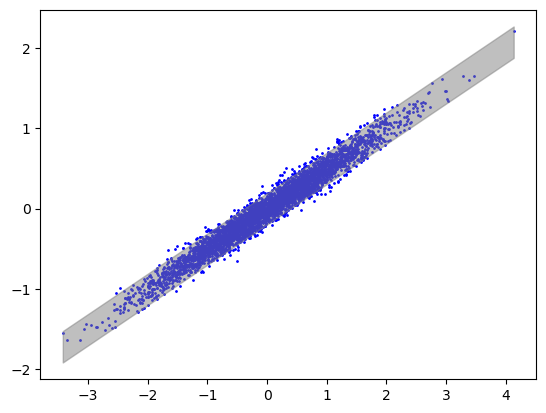

In [107]:
beta0 = .5
b0 = 0

x = generateX(n)
# x = generateX_unif(n)

y = generateLinearY(x, beta0, b0, sigma)

xtrain, ytrain, x_new, y_new = splitData(x, y, ntrain)

intervals = linearPredictionInterval(xtrain, ytrain, x_new, alpha)

cov_test = [1 if y_new[i] >= intervals[i, 0] and y_new[i] <= intervals[i, 1] else 0 for i in range(len(y_new))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction interval 
sorted_ix = np.argsort(x_new)
xgrid = x_new[sorted_ix]
ygrid = y_new[sorted_ix]


interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')


Percent covered on test data:  0.953


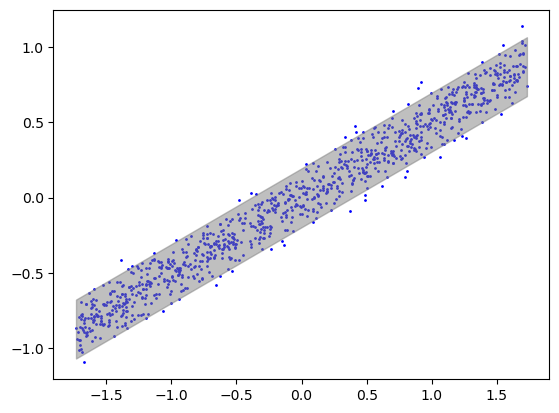

In [108]:
####conditional coverage: x now follows different distribution; could be selected adversarially too

x_test_new = generateX_unif(1000) # distributed differently from xtrain
ytest_new = generateLinearY(x_test_new, beta0, b0, sigma)
# use the linear model estimated earlier to generate prediction set
xtrain = xtrain.reshape(-1, 1)
n1 = xtrain.shape[0]
res = LinearRegression().fit(xtrain, ytrain)
betahat = res.coef_
bhat = res.intercept_
sigmahat = np.sqrt( np.sum((ytrain - xtrain @ betahat - bhat)**2)/(n1-2) )
xtilde = np.hstack([xtrain, np.ones((n1, 1))])
xtx = xtilde.T @ xtilde

yhat = x_test_new * betahat + bhat # estimate conditional mean using the model trained on (xtrain, ytrain)
t = stats.norm.ppf(1-alpha/2) # -1.96,  1.96
x_test_new1 = np.hstack([x_test_new.reshape(-1,1), np.ones((len(x_test_new), 1))])
mat = x_test_new1 @ np.linalg.inv(xtx) @ x_test_new1.T
s = sigmahat * np.sqrt(1 + mat.diagonal())
intervals_new = np.hstack([(yhat - t*s).reshape(-1, 1), (yhat + t*s).reshape(-1,1)])

cov_test = [1 if ytest_new[i] >= intervals_new[i, 0] and ytest_new[i] <= intervals_new[i, 1] else 0 for i in range(len(ytest_new))]
print('Percent covered on test data: ', np.mean(cov_test))

sorted_ix = np.argsort(x_test_new)
xgrid = x_test_new[sorted_ix]
ygrid = ytest_new[sorted_ix]
interval_grid_new = intervals_new[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid_new[:, 0], interval_grid_new[:, 1], color='gray', alpha=0.5, label='Prediction Interval')



I encourage you to try conformal prediction interval for this well-specified (working model is correct) example and compare the widths of the conformal prediction interval and the linear prediction interval (and the coverage ratio on the new (test) data too).

### Experiment 2

* true model is non-linear with heteroskedastic gaussian noise
* we fit linear model
* we use linear model prediction interval

In [109]:
def generateNonlinearY(x, sigma):
    def s(x):
        g = [1 if x[i] > 0 else abs(x[i])**2 + 1 for i in range(len(x))]
        return np.array(g)

    n = len(x)
    eps = np.random.randn(n) 
    y = 1.5*np.maximum(x, 0) + sigma * s(x) * eps
    return y

betahat = [1.40942583], bhat = 2.286292512335311, sigmahat = 0.21702976688711684
Percent covered on test data:  0.9662


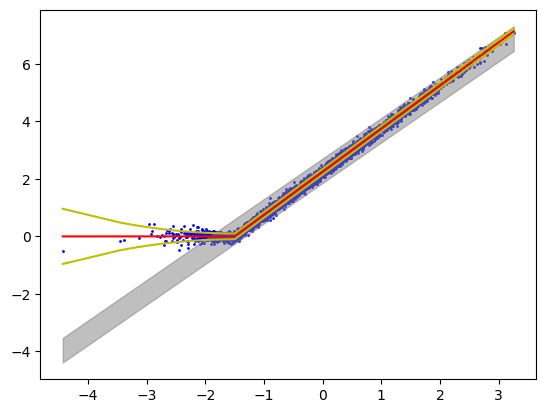

In [110]:
ntrain = 2000
n_new = 5000
n = ntrain + n_new

x = generateX(n)
shift = 3 #under-coverage, the heteroskedasticity leads to an under estimation of the variance
shift = -1.5 #over-coverage, the non-linearity, i.e. the miss specification of the model, leads to an over estimation of the variance and increases the width of the prediction interval
# shift=0

# x = generateX_unif(n,5)

y = generateNonlinearY(x - shift, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

intervals = linearPredictionInterval(xtrain, ytrain, xtest, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0), label='Regression function E[Y|X]', color='red')

stdgrid = [1 if xgrid[i]-shift > 0 else abs(xgrid[i]-shift)**2 + 1 for i in range(len(xgrid))] * np.array(sigma)
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0)+stdgrid, label='Regression function E[Y|X] + 1 std', color='y')
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0)-stdgrid, label='Regression function E[Y|X] - 1 std', color='y')

### Experiment 3

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a linear model
* we use conformal prediction interval

In [111]:
## resids are the absolute deviations ytrain2-muhat(xtrain2)
def conformalInterval(resids, ypred_new, alpha):
    n = len(resids)
    t = np.quantile(abs(resids), np.ceil((1-alpha)*(n+1))/n ) # find the (1-alpha)*(n+1)/n quantile of |residuals|
    print(f"The width of the conformal PI is {t}.")
    return np.hstack([(ypred_new - t).reshape(-1, 1), (ypred_new + t).reshape(-1,1)])

The width of the conformal PI is 0.3204069084910657.
Percent covered on test data:  0.9588


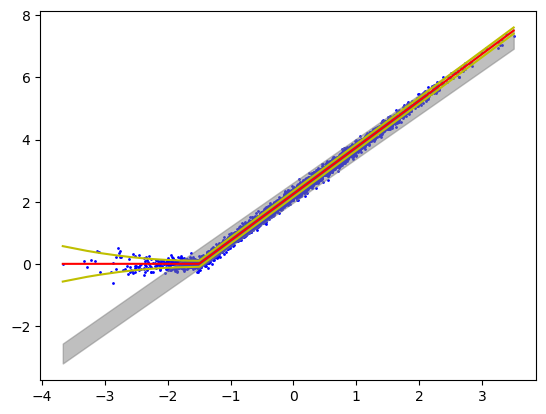

In [112]:
ntrain = 3000
n_new = 5000
n = ntrain + n_new

x = generateX(n)
shift = 3 #under-coverage in experiment 2
shift = -1.5 #over-coverage in experiment 2
# shift=0

y = generateNonlinearY(x - shift, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

regressor = LinearRegression().fit(xtrain1.reshape(-1, 1), ytrain1)
resids = ytrain2 - regressor.predict(xtrain2.reshape(-1, 1))

intervals = conformalInterval(resids, regressor.predict(xtest.reshape(-1, 1)), alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0), label='Regression function E[Y|X]', color='red')
stdgrid = [1 if xgrid[i]-shift > 0 else abs(xgrid[i]-shift)**2 + 1 for i in range(len(xgrid))] * np.array(sigma)
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0)+stdgrid, label='Regression function E[Y|X] + 1 std', color='y')
plt.plot(xgrid, 1.5*np.maximum(xgrid-shift, 0)-stdgrid, label='Regression function E[Y|X] - 1 std', color='y')

Note that np.mean(cov_test) is an estimate of P(Y_new is in conformal prediction interval(X_new)|xtrain, ytrain), not P(Y_new is in conformal prediction interval(X_new)), and might not be very close to 0.95. However if you run the previous block many many times and take average of all the subsequent coverage ratios, it will be very close to 0.95.

#### When the model is misspecified, conformal prediction interval will still have coverage, as long as the new data follow the same distribution as the (xtrain2_i, ytrain2_i). When the model is misspecified and the new data have different distribution, there's nothing we can do.

In [113]:
## No gurantee on the conditional coverage
x_test_new = generateX_unif(1000, 5) #distributed deferrently from xtrain
ytest_new = generateNonlinearY(x_test_new - shift, sigma)

intervals_new = conformalInterval(resids, regressor.predict(x_test_new.reshape(-1, 1)), alpha)

cov_test = [1 if ytest_new[i] >= intervals_new[i, 0] and ytest_new[i] <= intervals_new[i, 1] else 0 for i in range(len(ytest_new))]
print('Percent covered on test data: ', np.mean(cov_test))

The width of the conformal PI is 0.3204069084910657.
Percent covered on test data:  0.583


### Experiment 4

* true model is nonlinear with heteroskedastic Gaussian noise
* we fit a nonlinear model
* we use conformal prediction interval

In [114]:
x = generateX(n) 
shift = -0.7 #over-coverage
# shift = 3 #under-coverage

#x = generateX_unif(n, 5)

y = generateNonlinearY(x - shift, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data

class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x.squeeze()
    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

model = NNet(1, 6)
lr = 0.1
epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train1)
    loss = criterion(y_pred, y_train1)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch', epoch)


## compute residues on second half of training data
## and prediction intervals on test data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)
resids = ytrain2 - model(x_train2).squeeze().detach().numpy()

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test).squeeze().detach().numpy()

intervals = conformalInterval(resids, y_pred, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
The width of the conformal PI is 0.22055077916863286.
Percent covered on test data:  0.9426


#### The conformal prediction intervals here have smaller widths compared with the conformal prediction intervals generated in Experiment 3. This is because we use a better model to approximate $E[Y|X] = 1.5*max(x, 0)$.

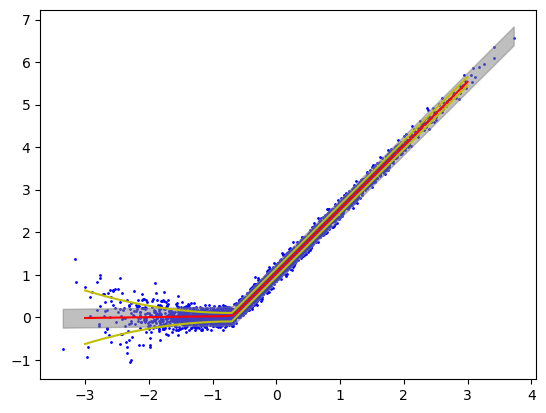

In [115]:
## plot fhat
xlinspace = np.linspace(-3, 3, 4000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
ylinspace = model(xlinspace_torch).squeeze().detach().numpy()

sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.plot(xlinspace, ylinspace, label='fhat', color = 'red')

stdgrid = [1 if xlinspace[i]-shift > 0 else abs(xlinspace[i]-shift)**2 + 1 for i in range(len(xlinspace))] * np.array(sigma)
plt.plot(xlinspace, 1.5*np.maximum(xlinspace-shift, 0)+stdgrid, label='Regression function E[Y|X] + 1 std', color='y')
plt.plot(xlinspace, 1.5*np.maximum(xlinspace-shift, 0)-stdgrid, label='Regression function E[Y|X] - 1 std', color='y')

Note that we still do not have conditional coverage.

In [116]:
x_test_new = generateX_unif(1000, 5) #distributed deferrently from xtrain
ytest_new = generateNonlinearY(x_test_new - shift, sigma)

x_test_new = torch.tensor(x_test_new.reshape(-1, 1), dtype=torch.float32)
y_pred_new = model(x_test_new).squeeze().detach().numpy()

intervals_new = conformalInterval(resids, y_pred_new, alpha)

cov_test = [1 if ytest_new[i] >= intervals_new[i, 0] and ytest_new[i] <= intervals_new[i, 1] else 0 for i in range(len(ytest_new))]
print('Percent covered on test data: ', np.mean(cov_test))

The width of the conformal PI is 0.22055077916863286.
Percent covered on test data:  0.718


## Conformal heteroskedastic regression: model the heteroskedasticity of the data
In the previous examples, we can see the confomal prediction intervals for different xs are of the same width. When the conditional variances are not constant, if we want to have 1-alpha coverage with a prediction band of a fixed width, it's inevitable we will have over coverage (much larger than 1-alpha) at where the conditional variances are low and under coverage (much lower than 1-alpha) at where the conditional variances are high. To overcome this, we model the cheteroskedasticity of the data, i.e. the conditional variance, and then conformalize the estimated conditional prediction interval into comformal prediction interval.

In [117]:
def generateX(n):
    x = np.random.randn(n)*1.5
    return(x)

def generateNonlinearY(x, sigma):
    n = len(x)
    eps1 = np.random.gamma(2, 2, n) - 4
    eps2 = np.random.normal(0, .5, n)
    
    y = 2*np.maximum(x, 0) + sigma * ( (x + .5) * eps1 + eps2)
    return y

def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


### Define neural network for heteroskedastic regression

In [118]:
class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2a = nn.Linear(hidden_dim, 1)
        self.layer2b = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        out1 = self.layer2a(x).squeeze() #E[Y|X] in the heteroscedastic regression case; lower quantile in the quantile regression case
        out2 = self.layer2b(x).squeeze() #log Var(Y|X)^0.5 in the heteroscedastic regression case; upper quantile in the quantile regression case
        return out1, out2


def heteroskedLoss(mu, log_nu, y):
    ##negative Gaussian likelihood
    return torch.mean( (y - mu)**2 / (2*torch.exp(log_nu)**2) + log_nu )

### Generate data and train neural network for heteroskedastic regression

In [119]:
ntrain = 1000
n_new = 1000
n = ntrain + n_new

sigma = .2 #noise level
alpha = 0.05 # 95% prediction interval for Y_new

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model2 = NNet(1, 10)
lr = 0.2
epochs = 400
optimizer = optim.Adam(model2.parameters(), lr=lr)

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        mu, log_nu = model2(x_batch)
        loss = heteroskedLoss(mu, log_nu, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print('epoch', epoch)


epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350


## Define residual interval function

In [120]:
# score = |Y-mu(X)|/sd(X)
# mu is the conditional mean E[Y|X]
# sigma is the conditional standard deviation Var(Y|X)^0.5
def conformalResidueInterval(scores, mu, sigma, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = mu - t*sigma
    y_out_u = mu + t*sigma
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

In [121]:

## compute non-conformity scores on second half of training data
## and prediction intervals on test data
x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

mu_2, log_nu_2 = model2(x_train2)
mu_2 = mu_2.detach().numpy()
log_nu_2 = log_nu_2.detach().numpy()    
nu_2 = np.exp(log_nu_2)

scores = np.abs(ytrain2 - mu_2)/nu_2

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
mu_pred, log_nu_pred = model2(x_test)
mu_pred = mu_pred.detach().numpy()
log_nu_pred = log_nu_pred.detach().numpy()
nu_pred = np.exp(log_nu_pred)

intervals = conformalResidueInterval(scores, mu_pred, nu_pred, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.955


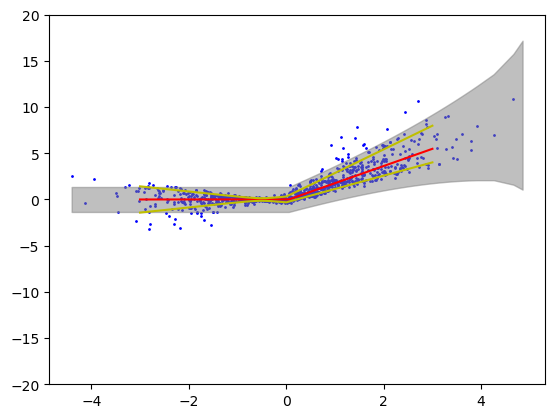

In [122]:
## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.ylim(-20, 20)

## plot fhat
xlinspace = np.linspace(-3, 3, 4000)
xlinspace_torch = torch.tensor(xlinspace, dtype=torch.float32).reshape(-1,1)
ylinspace, _ = model2(xlinspace_torch)
ylinspace = ylinspace.squeeze().detach().numpy()
plt.plot(xlinspace, ylinspace, label='fhat', color = 'red')
vargrid = [(xlinspace[i] + 0.5)**2 * 8 + 0.5 for i in range(len(xlinspace))]
stdgrid = [v**0.5 for v in vargrid] * np.array(sigma)
plt.plot(xlinspace, 2*np.maximum(xlinspace, 0)+stdgrid, label='Regression function E[Y|X] + 1 std', color='y')
plt.plot(xlinspace, 2*np.maximum(xlinspace, 0)-stdgrid, label='Regression function E[Y|X] - 1 std', color='y')



## Conformal quantile regression: model the heteroskedasticity of the data
The heteroskedastic regression works well when the data is generated following the model Y_i = X_i + s(X_i) * Z_i, where Z_i are i.i.d. noises, which is not the case in the previous example (the shape of the noise distributions are differnt for different xs). The idea of the conformal quantile regression is that we directly model the conditional quantiles and then conformalize the estimated conditional prediction interval into comformal prediction interval.

### Define neural network for quantile regression

In [123]:
class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2a = nn.Linear(hidden_dim, 1)
        self.layer2b = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        out1 = self.layer2a(x).squeeze() #lower quantile in the quantile regression case; E[Y|X] in the heteroscedastic regression case
        out2 = self.layer2b(x).squeeze() #upper quantile in the quantile regression case; log Var(Y|X)^0.5 in the heteroscedastic regression case
        return out1, out2
    
    
def quantileLoss(y_out_l, y_out_u, y, alpha):
    lower_loss = torch.max( (alpha/2)*(y - y_out_l), (alpha/2-1)*(y - y_out_l) )
    upper_loss = torch.max( (1-alpha/2)*(y - y_out_u), (-alpha/2)*(y - y_out_u) )
    return torch.mean(lower_loss + upper_loss)


### Generate data and train neural network for quantile regression

In [124]:
ntrain = 1000
n_new = 1000
n = ntrain + n_new

sigma = .2 #noise level
alpha = 0.05 # 95% prediction interval for Y_new

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model = NNet(1, 10)
lr = 0.2
epochs = 400
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_out_l, y_out_u = model(x_batch)
        loss = quantileLoss(y_out_l, y_out_u, y_batch, alpha)
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print('epoch', epoch)


epoch 0
epoch 50
epoch 100
epoch 150
epoch 200
epoch 250
epoch 300
epoch 350


### Define CQR interval function

In [125]:
# scores on holdout data, Q_alpha/2(x), Q_{1-alpha/2}(x)
def CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = y_out_l_pred - t
    y_out_u = y_out_u_pred + t 
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

### Create CQR intervals

In [126]:

## compute non-conformity scores on second half of training data
## and prediction intervals on new (test) data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

y_out_l2, y_out_u2 = model(x_train2)
y_out_l2 = y_out_l2.detach().numpy()
y_out_u2 = y_out_u2.detach().numpy()

scores = np.maximum(ytrain2 - y_out_u2, y_out_l2 - ytrain2)

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_out_l_pred, y_out_u_pred = model(x_test)
y_out_l_pred = y_out_l_pred.detach().numpy()
y_out_u_pred = y_out_u_pred.detach().numpy()

intervals = CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha)
# checking empirical coverage
cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.931


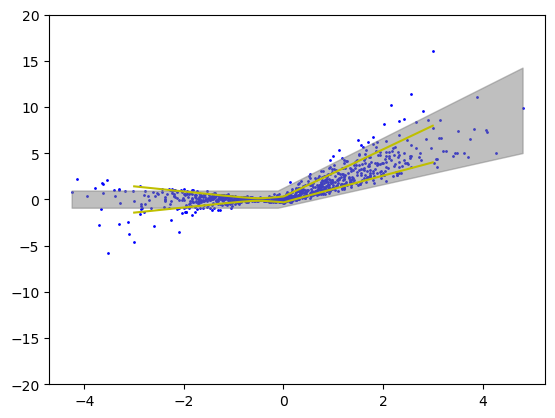

In [127]:
## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')
plt.ylim(-20, 20)

xlinspace = np.linspace(-3, 3, 4000)
vargrid = [(xlinspace[i] + 0.5)**2 * 8 + 0.5 for i in range(len(xlinspace))]
stdgrid = [v**0.5 for v in vargrid] * np.array(sigma)
plt.plot(xlinspace, 2*np.maximum(xlinspace, 0)+stdgrid, label='Regression function E[Y|X] + 1 std', color='y')
plt.plot(xlinspace, 2*np.maximum(xlinspace, 0)-stdgrid, label='Regression function E[Y|X] - 1 std', color='y')



#### Note that the CQR prediction intervals are of shorter length compared with the heteroskedastic regression prediction intervals.

## Conformal prediction set for classification 

Generate the data following multinomial logit model.

In [128]:
# Define the number of samples and features
ntrain = 1000
n_new = 1000
n = ntrain + n_new
num_features = 5
num_classes = 10

# Set the random seed for reproducibility
np.random.seed(0)

# Generate random feature data
x = np.random.randn(n, num_features)

# coefficients is of shape (num_classes, num_features)
# Generate random coefficients for the linear model
magnitude = 1 # the larger the easier the classification problem
coefficients = np.random.randn(num_classes, num_features)
row_norms = np.linalg.norm(coefficients, axis=1)
# Normalize each row by dividing by its L2 norm
coefficients = coefficients / row_norms[:, np.newaxis] * magnitude

# num_classes = 4.
# num_features = 3
# magnitude = 2 # the larger the easier the classification problem
# manually setting the coefficients for the linear model 
# coefficients = np.array([[2, -1, 0],
#                          [-1, 1, -0.5],
#                          [-0.7, 0.5, 1],
#                          [0.5, -0.5, 1.2]]) * magnitude

# Compute the linear scores for each sample and class
linear_scores = x @ coefficients.T

# Use the softmax function to convert scores into class probabilities
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
class_probs = softmax(linear_scores)
y = np.array([np.random.choice(class_probs.shape[1], 1, p=class_probs[i,:])[0] for i in range(n)])



### Train a classfication model you like on the train data. Here we use the (well-specified) multinomial logistic regression.

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [130]:
xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
# Train the model on the first half of the training data
model.fit(xtrain1, ytrain1)

# model prediction accuracy
y_pred_label = model.predict(xtrain2)
print(accuracy_score(ytrain2, y_pred_label))


0.274


#### Take a look at two train data and their scores.

In [131]:
y_pred_prob = model.predict_proba(xtrain2[10:12,])
row_indices = np.argsort(y_pred_prob, axis=1)
row_indices = row_indices[:,::-1]
sorted_y_pred_prob = np.take_along_axis(y_pred_prob, row_indices, axis=1)
cdf = sorted_y_pred_prob.cumsum(axis=1)
print("predicted conditional distribution for xtrain2_10:")
print(y_pred_prob[0,])
print(f"true label: {ytrain2[10]}")
print("predicted conditional distribution for xtrain2_11:")
print(y_pred_prob[1,])
print(f"true label: {ytrain2[11]}")

predicted conditional distribution for xtrain2_10:
[0.10596531 0.04630515 0.21097185 0.02890118 0.00584182 0.20859563
 0.16265232 0.0075292  0.15977575 0.0634618 ]
true label: 8
predicted conditional distribution for xtrain2_11:
[0.06054576 0.09178374 0.0357455  0.16901002 0.06587057 0.08802857
 0.06459994 0.14680684 0.09670745 0.18090159]
true label: 9


In [132]:
print("sorted conditional distribution for xtrain2_10:")
print(sorted(y_pred_prob[0,], reverse=True))
print("sorted conditional distribution for xtrain2_11:")
print(sorted(y_pred_prob[1,], reverse=True))

sorted conditional distribution for xtrain2_10:
[0.21097184628513896, 0.20859562518666688, 0.16265232096188, 0.15977574582578014, 0.10596531228329227, 0.06346179579046933, 0.04630514946897997, 0.028901183606299143, 0.007529198939037736, 0.0058418216524555085]
sorted conditional distribution for xtrain2_11:
[0.18090159336780476, 0.16901002281731825, 0.1468068434561216, 0.09670745138141826, 0.0917837382112053, 0.08802857499997, 0.0658705726705938, 0.06459994073259201, 0.060545759937085886, 0.03574550242589003]


When</br>
np.random.seed(0)</br>
ntrain = 1000</br>
num_features = 5</br>
num_classes = 10</br>
magnitude = 1,</br>

the nonconformity score of (xtrain2_10, ytrain2_10) is $0.21097184628513896\,(p_2) + 0.20859562518666688\,(p_5) + 0.16265232096188\,(p_6) + 0.15977574582578014\,(p_8)$, and</br>
the nonconformity score of (xtrain2_11, ytrain2_11) is $0.18090159336780476\,(p_9)$.


### Calculate the nonconformity scores.

In [133]:
# Make predictions on the second half of the training data
y_pred_prob = model.predict_proba(xtrain2)
# sort the probabilities of each row
row_indices = np.argsort(y_pred_prob, axis=1) # ascending order
row_indices = row_indices[:,::-1] # descending order
sorted_y_pred_prob = np.take_along_axis(y_pred_prob, row_indices, axis=1)
# calculate the cumulative sum
cdf = sorted_y_pred_prob.cumsum(axis=1)
# the score is the sum of the predicted probabilities that are larger than the predicted probability of the true label
# np.argwhere(row_indices[i, :]==ytrain2[i])] is to get the ranking of the predicted probability of the true label among the predicted probabilities
scores = [cdf[i, np.argwhere(row_indices[i, :]==ytrain2[i])][0][0] for i in range(len(ytrain2))]

#### Define conformal prediction set function.

In [134]:
# scores on holdout data, Q_alpha/2(x), Q_{1-alpha/2}(x)
def Cnflset(scores, y_pred_prob, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    print(f"threshold = {t}")
    row_indices = np.argsort(y_pred_prob, axis=1)
    row_indices = row_indices[:,::-1]
    # Sort the rows based on the indices
    sorted_y_pred_prob = np.take_along_axis(y_pred_prob, row_indices, axis=1)
    cdf = sorted_y_pred_prob.cumsum(axis=1)
    ind = cdf <= t
    return [row_indices[i, ind[i, :]] for i in range(y_pred_prob.shape[0])] #list of arrays (predicion sets)

In [135]:
alpha = .05

y_pred_prob = model.predict_proba(xtest)
conformalsets = Cnflset(scores, y_pred_prob, alpha)

coverage = [ytest[i] in conformalsets[i] for i in range(len(ytest))]
size = [len(ps) for ps in conformalsets]

print('Percent covered on test data: ', sum(coverage)/len(coverage))
print(f"Average size of the prediction set: {sum(size)/len(size)}; number of classes: {coefficients.shape[0]}")

threshold = 0.9848867520236859
Percent covered on test data:  0.961
Average size of the prediction set: 8.117; number of classes: 10
